In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')

import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
from torch.autograd import Variable
from captum.attr import IntegratedGradients

from dataset import Dataset
from net import define_network

In [2]:
torch.manual_seed(123)
np.random.seed(123)

In [3]:
def evaluate(eval_file, model_file, gene_name):
    eval_set = Dataset(eval_file, gene_name, is_train=True)
    data_loader = data.DataLoader(eval_set, batch_size=1, shuffle=False)

    input_size, output_size = tuple(eval_set[0][0].shape), eval_set[0][1].shape[0]
    patch_size = tuple([int(i / 8) for i in input_size])
    model = torch.nn.DataParallel(define_network(input_size, patch_size, output_size))
    model.load_state_dict(torch.load(model_file))
    model.cuda()
    model.eval()
    ig = IntegratedGradients(model)

    _datas = np.load(eval_file, allow_pickle=True)
    important_genes = dict(Astro=dict(), Endo=dict(), OPC=dict(), ODC=dict())
    for index, batch in enumerate(data_loader, 1):
        if _datas[index-1]['cell_type'] != 'ODC':
            continue
        _important_genes = important_genes[_datas[index-1]['cell_type']]
        input = Variable(batch[0]).cuda().unsqueeze(1)
        target = Variable(batch[1]).cuda().unsqueeze(1) / 10
        
        attributions = torch.zeros(input.reshape(-1).shape).cuda()
        for i in range(target.shape[-1]):
            attributions += ig.attribute(input, target=(0, i))[0, 0].reshape(-1)
        attributions = attributions.cpu().detach().numpy()
        for i in range(len(attributions)):
            if i not in _important_genes.keys():
                _important_genes[i] = 0
            _important_genes[i] += attributions[i]
        
    return important_genes

important_genes = evaluate(
    '/lmh_data/data/sclab/sclab/promoter/eval_dataset.npy',
    '/lmh_data/data/sclab/sclab/promoter/tmp/MBP/model_epoch_9.pth', 'MBP')
important_genes

{'Astro': {},
 'Endo': {},
 'OPC': {},
 'ODC': {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.009029859094880521,
  16: 0.0,
  17: 0.0,
  18: 0.0,
  19: -0.05316577525809407,
  20: -0.00997080048546195,
  21: 0.0,
  22: -0.031383153051137924,
  23: 0.0,
  24: -0.27433227421715856,
  25: 0.0,
  26: 0.268290210980922,
  27: 0.0,
  28: 0.0,
  29: 0.0,
  30: 0.0,
  31: 0.0,
  32: 0.0,
  33: 0.0,
  34: 0.04012447444256395,
  35: 0.005990901845507324,
  36: 0.0,
  37: -0.09597520879469812,
  38: -0.07641682680696249,
  39: 0.17076891637407243,
  40: 0.031071302015334368,
  41: 0.11080508842132986,
  42: 0.0,
  43: 0.042336170794442296,
  44: 0.0,
  45: -0.29554619267582893,
  46: 0.13690145767759532,
  47: -0.1875230772420764,
  48: 0.0170101203257218,
  49: -0.03436617832630873,
  50: 0.09893135190941393,
  51: -0.11010023206472397,
  52: 0.047028143890202045,
  53: 0.128034893

In [4]:
scRNA_head = np.load('/lmh_data/data/sclab/sclab/promoter/eval_dataset.npy', allow_pickle=True)[0]['scRNA_head']

def find_special_genes(important_genes, cell_type):
    genes = pd.DataFrame(
        sorted(important_genes[cell_type].items(), key=lambda x: x[1], reverse=True), columns=['index', 'value']
    ).set_index('index')
    genes = genes.sort_values(by=['value'], ascending=False)
    return genes

genes = find_special_genes(important_genes, 'ODC')
genes['name'] = scRNA_head[list(genes.index)]
genes.to_csv('tmp/related_genes_MBP_promoter.csv')
genes

,value,name
index,,
18428,205.858234,PCDH9
15794,109.527422,MALAT1
7226,87.236630,SPOCK3
15663,82.801300,FTH1
28301,70.822743,PLP1
...,...,...
3878,-30.650847,PKP4
21156,-34.724002,RBFOX1
23880,-46.331866,MBP


In [5]:
genes = genes[:100]
gene_names = genes.name.values
gene_names

array(['PCDH9', 'MALAT1', 'SPOCK3', 'FTH1', 'PLP1', 'XIST', 'PIP4K2A',
       'TMTC2', 'ANK2', 'IL1RAPL1', 'SEPT7', 'ST18', 'TRIM2', 'QKI',
       'PTK2', 'ALCAM', 'PDE4B', 'KCNH8', 'CNP', 'ERBB4', 'ZBTB20',
       'FRYL', 'UNC5C', 'SIK3', 'KIRREL3', 'TTLL7', 'PTPRK', 'ERMN',
       'FTX', 'NPAS3', 'PDE1A', 'FGFR2', 'PHLPP1', 'AUTS2', 'DST',
       'NKAIN2', 'TMEFF2', 'FOLH1', 'TMEM165', 'JMJD1C', 'HSPA1A', 'UGT8',
       'MYRF', 'DMD', 'EXOC6B', 'NTM', 'DNAJC6', 'PLXDC2', 'ZNF638',
       'AK5', 'NCAM1', 'PTPRD', 'LSAMP', 'MBNL2', 'FAR1', 'SLAIN1',
       'ZSWIM6', 'N4BP2L2', 'RERE', 'MARCH1', 'TJP1', 'VRK2', 'DIP2B',
       'FBXL7', 'LAMP2', 'NCAM2', 'USP47', 'CCDC88A', 'NRXN1', 'CTNNA3',
       'SEMA6A', 'CALM2', 'MED13L', 'GRID1', 'SRPK2', 'CLDND1', 'HIPK2',
       'MAPK10', 'PPFIA2', 'CNTNAP2', 'PSD3', 'NEGR1', 'DOCK3', 'FTL',
       'FAF1', 'CRYAB', 'SOX2-OT', 'ANKRD28', 'DOCK4', 'PLEKHH1', 'GRIA4',
       'CTNND2', 'DOCK9', 'EDIL3', 'ELF1', 'ANO4', 'PHF14', 'FBXO7',
       'FAM1

In [6]:
literome = pd.read_csv('/lmh_data/data/sclab/source/literome/pathway-extraction.txt', sep='\t')

def get_filter(gene_name, num=0):
    if num == 2:
        return pd.DataFrame()
    _filter_Causes = literome[literome.Theme.str.contains(gene_name)].Cause.str.split(':').str[-1].str.split('_')
    _filter_Themes = literome[literome.Cause.str.contains(gene_name)].Theme.str.split(':').str[-1].str.split('_')
    _filter_genes = set()
    for _filter in pd.concat([_filter_Causes, _filter_Themes]).values:
        _filter_genes = _filter_genes | set(_filter)
    _filters = [get_filter(_name, num+1) for _name in _filter_genes]
    _filters.append(_filter_Causes)
    _filters.append(_filter_Themes)
    return pd.concat(_filters)

_filters = get_filter('MBP')

In [7]:
_filter_genes = set()
for _filter in _filters.values:
    _filter_genes = _filter_genes | set(_filter[0])
print(len(_filter_genes & set(gene_names)) / len(gene_names))
_filter_genes & set(gene_names)

0.74


{'AK5',
 'ALCAM',
 'ANK2',
 'ANKRD28',
 'ANO4',
 'AUTS2',
 'CALM2',
 'CCDC88A',
 'CNP',
 'CNTNAP2',
 'CRYAB',
 'CTNNA3',
 'CTNND2',
 'DMD',
 'DOCK3',
 'DOCK4',
 'DOCK9',
 'DST',
 'ELF1',
 'ERBB4',
 'ERMN',
 'FAF1',
 'FAR1',
 'FBXL7',
 'FBXO7',
 'FGFR2',
 'FOLH1',
 'FTL',
 'FTX',
 'GRIA4',
 'GRID1',
 'HIPK2',
 'IL1RAPL1',
 'JMJD1C',
 'KCNH8',
 'LAMP2',
 'MALAT1',
 'MAPK10',
 'MARCH1',
 'MBNL2',
 'MED13L',
 'N4BP2L2',
 'NCAM1',
 'NCAM2',
 'NKAIN2',
 'NPAS3',
 'NRXN1',
 'NTM',
 'PCDH9',
 'PDE1A',
 'PDE4B',
 'PHF14',
 'PHLPP1',
 'PIP4K2A',
 'PLP1',
 'PPFIA2',
 'PTK2',
 'PTPRK',
 'QKI',
 'SEMA6A',
 'SEPT7',
 'SIK3',
 'SRPK2',
 'ST18',
 'TJP1',
 'TMEM165',
 'TTLL7',
 'UGT8',
 'USP47',
 'VRK2',
 'XIST',
 'ZBTB20',
 'ZNF536',
 'ZNF638'}

In [8]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(eval_file, model_file, gene_name, ignore_genes_index):
    eval_set = Dataset(eval_file, gene_name, is_train=True)
    data_loader = data.DataLoader(eval_set, batch_size=1, shuffle=False)

    input_size, output_size = tuple(eval_set[0][0].shape), eval_set[0][1].shape[0]
    patch_size = tuple([int(i / 8) for i in input_size])
    model = torch.nn.DataParallel(define_network(input_size, patch_size, output_size))
    model.load_state_dict(torch.load(model_file))
    model.cuda()
    model.eval()

    _datas = np.load(eval_file, allow_pickle=True)
    pearsons = []
    for index, batch in enumerate(data_loader, 1):
        if _datas[index-1]['cell_type'] != 'ODC':
            continue
        input = Variable(batch[0]).cuda().unsqueeze(1)
        target = Variable(batch[1]).cuda().unsqueeze(1).cpu().numpy()
        
        _shape = input.shape
        input = input.reshape(-1)
        input[ignore_genes_index] = 0
        input = input.reshape(_shape)
        output = model(input).detach().cpu().numpy()
        
        pearson = stats.pearsonr(output[0, 0], target[0, 0])[0]
        pearsons.append(pearson)
        
    return pearsons

In [9]:
ignore_preds_info = []
for i in range(0, 101, 10):
    pearsons = evaluate(
        '/lmh_data/data/sclab/sclab/promoter/eval_dataset.npy',
        '/lmh_data/data/sclab/sclab/promoter/tmp/MBP/model_epoch_9.pth', 'MBP', list(genes.index)[:i])
    _df = pd.DataFrame({'pearson': pearsons, 'ignore proportion': i})
    ignore_preds_info.append(_df)

ignore_preds_info = pd.concat(ignore_preds_info, axis=0, ignore_index=True)

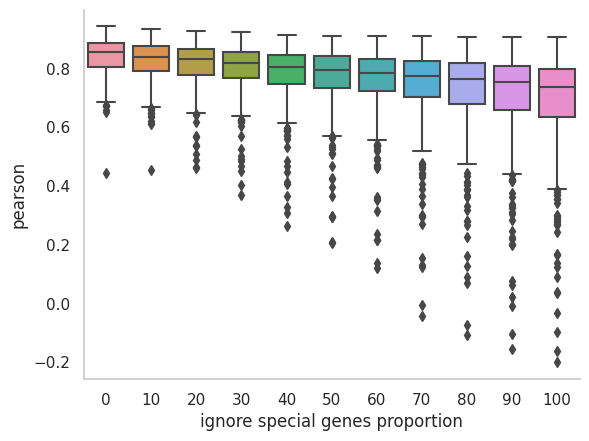

In [10]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x='ignore proportion', y='pearson', data=ignore_preds_info
)

sns.despine()
plt.grid(False)

plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

plt.show()

Text(0, 0.5, 'pearson')

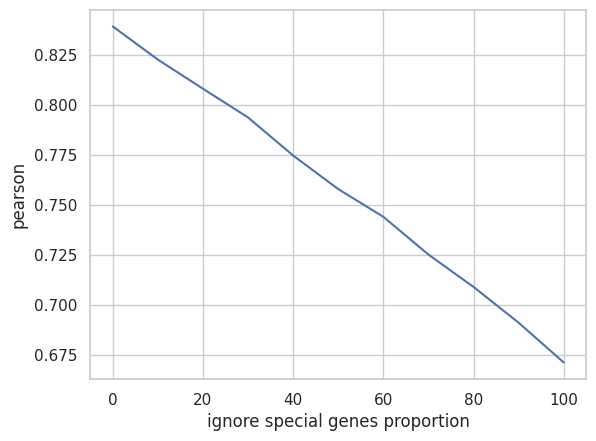

In [11]:
_group_by = ignore_preds_info.groupby('ignore proportion').mean()
x, y = _group_by.index, _group_by.values.flatten()
plt.plot(x, y)
plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

In [12]:
ignore_preds_info = []
for i in range(0, 101, 10):
    pearsons = evaluate(
        '/lmh_data/data/sclab/sclab/promoter/eval_dataset.npy',
        '/lmh_data/data/sclab/sclab/promoter/tmp/MBP/model_epoch_9.pth', 'MBP', list(genes.index)[max(i-10, 0):i])
    _df = pd.DataFrame({'pearson': pearsons, 'ignore proportion': i})
    ignore_preds_info.append(_df)

ignore_preds_info = pd.concat(ignore_preds_info, axis=0, ignore_index=True)

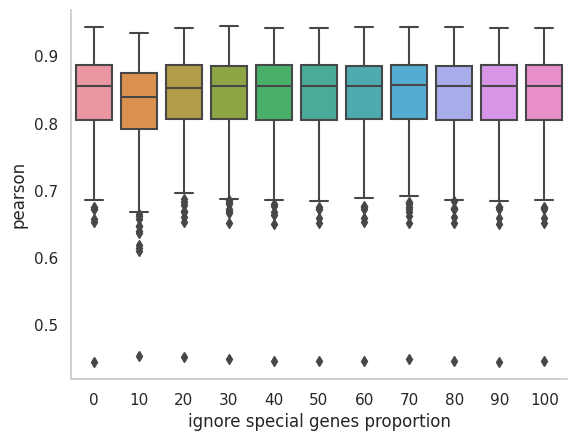

In [13]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x='ignore proportion', y='pearson', data=ignore_preds_info
)

sns.despine()
plt.grid(False)

plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

plt.show()

Text(0, 0.5, 'pearson')

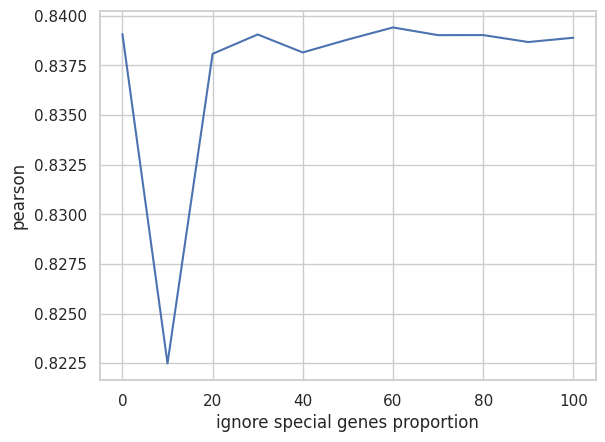

In [14]:
_group_by = ignore_preds_info.groupby('ignore proportion').mean()
x, y = _group_by.index, _group_by.values.flatten()
plt.plot(x, y)
plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

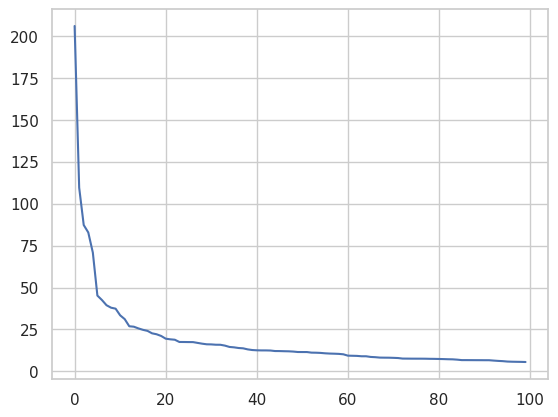

In [15]:
y = genes.value.values.flatten()

x = [i for i in range(len(y))]
plt.plot(x, y)